In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.vision import models
import torch

import sys
sys.path.append('../')
from src.types.tensor_tiles import BrightfieldTile, FluorescenceTile
from src.stats_reader import DataStats
from src.transforms.augmentations import PairAugmentations
from src.transforms.pair_transform import PairTransform

/mnt/945C2D6E5C2D4BF4/Kaggle/adipocyte-cell-imaging-raehmae/venv/lib/python3.7/site-packages/fastcore/foundation.py:52: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
bs = 2
zoom = 60
stats_path = '../configs/data_statistics.json'
STATS = DataStats(stats_path, zoom)

path = '../input/preview_tile_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

,fn,fold,slide_name,start_x,start_y,tile_sz,slide_width,slide_height,target_fn
0,input_60_128/AssayPlate_Greiner_#655090_D04__0__0.npy,2,AssayPlate_Greiner_#655090_D04,0,0,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__0.npy
1,input_60_128/AssayPlate_Greiner_#655090_D04__0__96.npy,2,AssayPlate_Greiner_#655090_D04,0,96,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__96.npy
2,input_60_128/AssayPlate_Greiner_#655090_D04__0__192.npy,3,AssayPlate_Greiner_#655090_D04,0,192,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__192.npy
3,input_60_128/AssayPlate_Greiner_#655090_D04__0__288.npy,4,AssayPlate_Greiner_#655090_D04,0,288,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__288.npy
4,input_60_128/AssayPlate_Greiner_#655090_D04__0__384.npy,0,AssayPlate_Greiner_#655090_D04,0,384,128,2556,2156,target_60_128/AssayPlate_Greiner_#655090_D04__0__384.npy


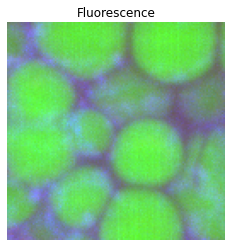

In [4]:
targ = FluorescenceTile.create(os.path.join(path, df.iloc[100].target_fn), STATS)
targ.show();

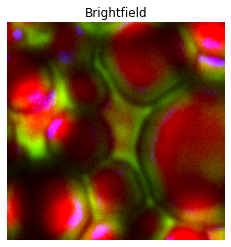

In [5]:
s = BrightfieldTile.create(os.path.join(path, df.iloc[25].fn), STATS)
s.show();

In [6]:
brightfield_paths = [os.path.join(path, fn) for fn in df.fn.values]
fluorescence_paths = [os.path.join(path, fn) for fn in df.target_fn.values]
is_train = [fold != 0 for fold in df.fold.values]
df['is_val'] = ~np.array(is_train)

augmentations = PairAugmentations()

tfm = PairTransform(
    brightfield_paths, 
    fluorescence_paths, 
    stats=STATS,
    augment_func=augmentations,
    augment_samples=is_train
)

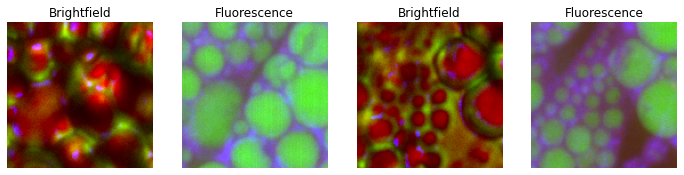

In [7]:
splitter = FuncSplitter(lambda o: df[df.fn == str(o).replace(path,'')].is_val.values[0])
splits = splitter(brightfield_paths)

tls = TfmdLists(range(len(brightfield_paths)), tfm, splits=splits)
dls = tls.dataloaders(bs=bs)
dls.show_batch()

In [8]:
def resnet50_7chan(pretrained=True):
    resnet = models.resnet50(pretrained=pretrained)
    conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)
    if pretrained:
        w = resnet.conv1.weight
        conv1.weight = nn.Parameter(torch.cat((w,
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:])
              ),dim=1))
    resnet.conv1 = conv1
    return resnet

In [9]:
learn = unet_learner(dls, resnet50_7chan, n_out=3, loss_func=MSELossFlat(axis=1))

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

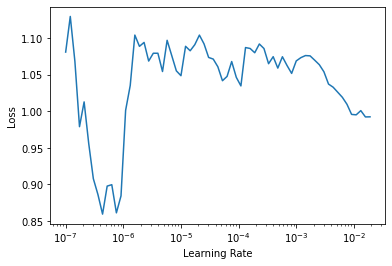

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.907480,1.263088,01:24


epoch,train_loss,valid_loss,time
0,0.766518,0.819669,01:27
1,0.652919,0.789780,01:27
2,0.645160,0.742592,01:27
3,0.694587,0.676867,01:27
4,0.610285,0.656634,01:27
5,0.595467,0.649350,01:27
6,0.598739,0.607788,01:27
7,0.566246,0.602844,01:27


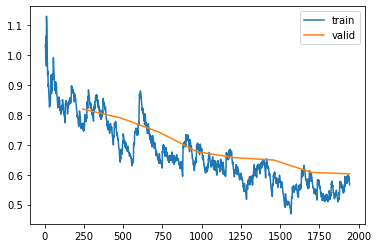

In [12]:
learn.recorder.plot_loss()

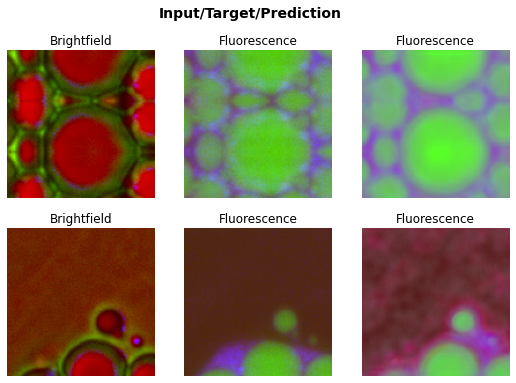

In [13]:
learn.show_results()

In [14]:
learn.fit_flat_cos(20, lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.581779,0.604736,01:28
1,0.559246,0.581832,01:28
2,0.526766,0.591685,01:28
3,0.591777,0.562406,01:28
4,0.538870,0.560147,01:28
5,0.454421,0.570760,01:28
6,0.468614,0.527150,01:28
7,0.504587,0.557283,01:28
8,0.446853,0.535666,01:28
9,0.445451,0.584173,01:28


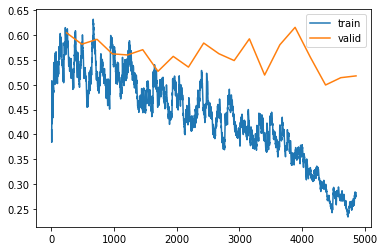

In [15]:
learn.recorder.plot_loss()

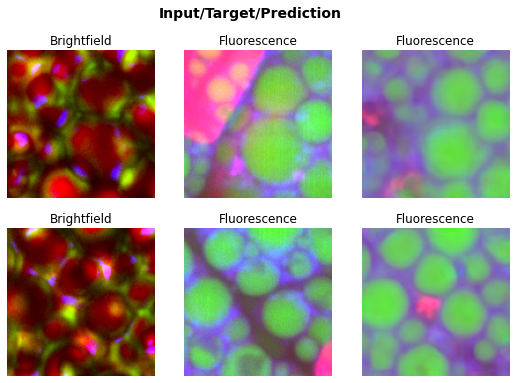

In [18]:
learn.show_results()

In [19]:
learn.fit_flat_cos(20, lr=5e-5)

epoch,train_loss,valid_loss,time
0,0.260379,0.539309,01:27
1,0.267303,0.479903,01:27
2,0.270844,0.489155,01:27
3,0.244040,0.494400,01:27
4,0.240390,0.521298,01:27
5,0.245943,0.501320,01:27
6,0.221710,0.496580,01:27
7,0.211497,0.480597,01:27
8,0.223883,0.475351,01:27
9,0.195040,0.448037,01:27


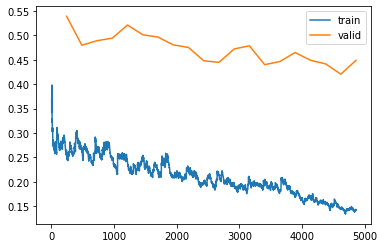

In [20]:
learn.recorder.plot_loss()

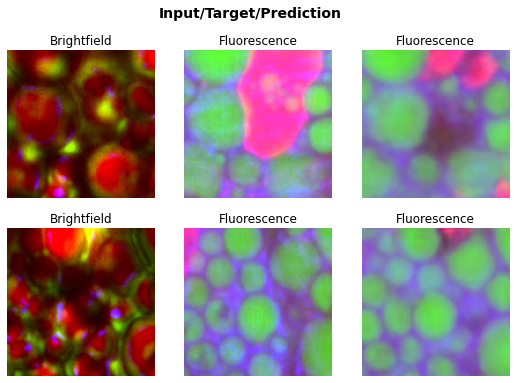

In [21]:
learn.show_results()

In [22]:
learn.fit_flat_cos(20, lr=1e-5)

epoch,train_loss,valid_loss,time
0,0.137576,0.419074,01:27
1,0.144224,0.425216,01:27
2,0.145194,0.421139,01:27
3,0.133732,0.431716,01:27
4,0.129643,0.428263,01:27
5,0.132648,0.436787,01:27
6,0.135668,0.429844,01:27
7,0.135592,0.433425,01:27
8,0.121285,0.427190,01:27
9,0.125966,0.422303,01:27


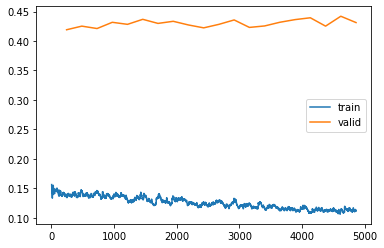

In [23]:
learn.recorder.plot_loss()

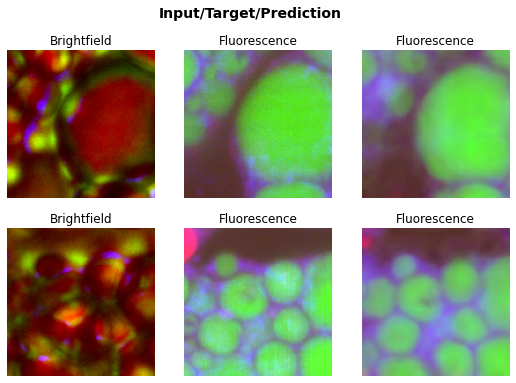

In [25]:
learn.show_results()